# Equation
# $$ \dot{z} (t)= iz$$

## Initial condition:
# $$z(0) = 1$$

# Solutions
# $$z(t) = e^{it} = \cos t + i \sin t$$
# $$u(t) = \mbox{Real}z(t) = \cos t$$
# $$v(t) = \mbox{Im}z(t)   = \sin t$$

In [1]:
import tensorflow as tf
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import time

2022-11-16 11:35:12.599007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 11:35:12.995553: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-16 11:35:13.074475: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 11:35:13.931207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
tf.__version__
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


2022-11-16 11:35:16.383927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 11:35:17.602634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:35:17.622009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:35:17.622399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

2022-11-16 11:35:19.661328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:35:19.661821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:35:19.662128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
class MyDense(tf.keras.layers.Layer):
    '''
    Inputs:
    
    units : number of neurons
    initialization = 0,1
           if activations are:
           init =0(He): ReLU, Leaky ReLU, ELU, GELU, Swish, Mish
           init =1(Xavier_Glorot): None, tanh, sigmoid, softmax 
           
    activation: activation to be use either string or callable
    
    
    Output:
            returns activation(wx+b) with appropriate initialization
    
    '''
    def __init__(self, units = 20, initialization=None, activation = None): #None = gives basic activation
        super(MyDense, self).__init__()
        self.units = units   
        self.init = initialization
        
        if activation == 'mish':
            self.activation = tf.keras.activations.get(self.mish_activation)
        else:
            self.activation = tf.keras.activations.get(activation)
       
    @tf.function
    def mish_activation(self, x):
        print(f'called_mish')
    #     mish(x) = xtanh(softsplus(x))  it needs  He initialization
        return x*tf.math.tanh(tf.nn.softplus(x))       
    
    
# We get them from the shape of w= shape
# shape[0] : number of inputs to the neuron
# shape[1] : number of output from the neuron
#     @tf.function(reduce_retracing=True)
    def Xavier_Glorot_initializer(self,shape, dtype=tf.float32):
        '''
        Xavier Glorot: initialization must be used for the following activations:
        None, tanh, sigmoid, softmax

       input: 
            shape = [number of columns, units]

       output:
               samples normal distribution of mean = 0 stddev = sqrt(2./inputs_shape+units)
        '''
        print('Initial weight with  Xavier Glorot ')
        
        shape_to_float = tf.cast(shape, dtype=tf.float32)
        fanin = shape_to_float[0]
        fanout = shape_to_float[1]
        stddev = tf.sqrt(2. /(fanin+fanout)  )
        return tf.random.normal(shape, stddev=stddev, dtype=dtype)
    
#     @tf.function(reduce_retracing=True) 
    def He_initializer(self,shape,dtype = tf.float32):
        '''
        input: 
                shape = [number of columns, units]

        He (aka He normal)initialization must be used for the following activations:
        ReLU, Leaky ReLU, ELU, GELU, Swish, Mish

        He initialization:
        random normal with variance and mean of 2/fanin = 2/no. of inputs = 2/inputs
        '''
        shape_to_float = tf.cast(shape, dtype=tf.float32)
#         print(f'INIT shape = {shape}, dtype = {shape.dtype}')
#         fanin = tf.constant(shape[0], dtype = tf.float32)
        fanin = shape_to_float[0]
#         print(f'fanin = {fanin}')
        stddev = tf.sqrt(2. /fanin)
#         print(f'stddev = {stddev}')
        print('Initial weight with  He')
        return tf.random.normal(shape, stddev=stddev, dtype=dtype)        

#     Initialize kernel aka w
    def init_w(self, input_shape):
        shape = [input_shape[-1], self.units]
        shape = tf.constant(shape, dtype=tf.int32)

        if self.init == 0:
#             Initialize with He : Relu and variants activation functions
            value = self.He_initializer(shape)
        else:
#             Initialize with Xavier_Glorot : None, tanh, sigmoid, softmax activation functions
            value = self.Xavier_Glorot_initializer(shape)
            
        return tf.Variable(name = 'kernel', initial_value=value ,trainable = True )

#     Initialize biase aka b
    def init_b(self):
        value = tf.zeros(self.units)
        return tf.Variable(name = 'bias', initial_value=value ,trainable = True )    
       
        
    def build(self, input_shape):
        self.w = self.init_w(input_shape)
        self.b = self.init_b()
        
    def call(self, inputs):
        out_put = self.activation(tf.matmul(inputs, self.w) + self.b)
        return out_put

In [5]:
class Z_approx(tf.keras.Model):
    def __init__(self,num_of_hid_layers = None, units_per_layer = None, num_out=1, initialization=None, activation=None ):
        super(Z_approx,self).__init__()
        self.num_of_hid_layers = num_of_hid_layers
        self.units_per_layer = units_per_layer
        self.num_out = num_out
        self.init = initialization
        self.normalize = tf.keras.layers.Normalization()
        
        if self.init == 0:
            kerner_init = tf.keras.initializers.he_normal()
        else:
            kerner_init = tf.keras.initializers.glorot_normal()
            
        
        
        
        self.initialization = initialization
        self.activation = activation
        
        
        self.hidden_layers = [MyDense(self.units_per_layer, self.initialization, self.activation) 
                              for _ in range(self.num_of_hid_layers)]
        
        self.out = MyDense(units=self.num_out, initialization=self.initialization)
        
        self.bn = [tf.keras.layers.BatchNormalization() for _ in range(self.num_of_hid_layers)]
    
    def call(self, inputs):
        '''
        Add BN before since the layer includes activations
        
        '''
        
        for i in range(self.num_of_hid_layers):
            if i == 0:
                x = self.normalize(inputs)
                x = self.bn[i](x)
            else:
                x = self.bn[i](x)
                
            x = self.hidden_layers[i](x)
            
        return self.out(x)          

In [6]:
t = tf.linspace(0,1,2000)[:,tf.newaxis]
t.shape

2022-11-16 11:35:22.494104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:35:22.494679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:35:22.495094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:35:22.495515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:35:22.495905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

TensorShape([2000, 1])

In [7]:
z_hat = Z_approx(num_of_hid_layers = 10, units_per_layer = 20, num_out=2, initialization = 0,activation = 'mish')
z_hat.build(t.shape)

Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He


In [12]:
z_hat(t)[:,:1] == z_hat(t)[:,0:1] 

<tf.Tensor: shape=(2000, 1), dtype=bool, numpy=
array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])>

In [43]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(t)
    u = z_hat(t)[:,:1]
    v = z_hat(t)[:,1:2] 
dudt = tf.cast(tape.gradient(u,t), dtype=tf.float32)
dvdt =  tf.cast(tape.gradient(v,t),dtype=tf.float32)
del tape

In [44]:
u.shape,v.shape

(TensorShape([2000, 1]), TensorShape([2000, 1]))

In [45]:
complex_der = tf.complex(dudt,dvdt)

In [46]:
z_fun =  tf.complex(u,v)
z_fun[:3]

<tf.Tensor: shape=(3, 1), dtype=complex64, numpy=
array([[ 0.        +0.0000000e+00j],
       [-0.00014208+5.5181139e-05j],
       [-0.00028421+1.1042586e-04j]], dtype=complex64)>

In [47]:
rhs = (z_fun*1.j)

In [48]:
tf.math.real(complex_der)[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.2836204], dtype=float32)>

In [49]:
tf.math.real(rhs)[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [53]:
f1 = tf.math.real(complex_der) - tf.math.real(rhs) #Real
f2 = -tf.math.imag(complex_der) + tf.math.imag(rhs) #Imaginary

In [55]:
u1,u2,_,_ = pinn.ode_ic(t)

In [57]:
tf.reduce_all(u1==f1)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [58]:
tf.reduce_all(u2==f2)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [60]:
def equations(u,v,dudt,dvdt):
#     derivatives must be dtype tf.float32
#     dzdt = iz(t)
    dzdt = tf.complex(dudt,dvdt) # dzdt = dudt + idvdt . 
    z = tf.complex(u,v)
    rhs = z*1.j
    
#     real(LHS)-Real(RHS) = -Imag(LHS)+Img(RHS) Equation from PINN paper
    
    f_real = tf.math.real(dzdt) - tf.math.real(rhs) # = real(LHS)-Real(RHS)
    f_imag = -tf.math.imag(dzdt) + tf.math.imag(rhs) # = -Imag(LHS)+Img(RHS)
    return f_real,f_imag

In [62]:
f_real,f_imag = equations(u,v,dudt,dvdt)

In [63]:
tf.reduce_all(u1==f_real)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [64]:
tf.reduce_all(u2==f_imag)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [65]:
class PINN:
    def __init__(self, t, model,z_init,optim):
        self.model = model
        self.t = t
        self.x_init = z_init[0]
        self.y_init = z_init[1]
        self.optim = optim

        
    def get_derivatives(self,t):
        '''
        Calculate the derivatives and function that correspond to the ode

        input:
                t : independent variant

        output:
                value and corresponding derivative

        '''
        
#         z = u + iv
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)         
            u = self.model(t)[:,0:1]
            v = self.model(t)[:,1:2]
        dudt = tf.cast(tape.gradient(u,t),dtype=tf.float32)
        dvdt = tf.cast(tape.gradient(v,t),dtype=tf.float32)  
        del tape
        
        return u,v, dudt,dvdt
    
    def equations(self, u,v,dudt,dvdt):
    #     derivatives must be dtype tf.float32
    #     dzdt = iz(t)
        dzdt = tf.complex(dudt,dvdt) # dzdt = dudt + idvdt . 
        z = tf.complex(u,v)
        rhs = z*1.j

    #     real(LHS)-Real(RHS) = -Imag(LHS)+Img(RHS) Equation from PINN paper

        f_real = tf.math.real(dzdt) - tf.math.real(rhs) # = real(LHS)-Real(RHS)
        f_imag = -tf.math.imag(dzdt) + tf.math.imag(rhs) # = -Imag(LHS)+Img(RHS)
        return f_real,f_imag
        
    def ode_ic(self,t):
        u,v, dudt,dvdt  = self.get_derivatives(t)
        f_real,f_imag = self.equations(u,v, dudt,dvdt)
        u1 =  f_real
        u2 =  f_imag
#         Initial conditions
        u0,v0,_,_ = self.get_derivatives(tf.zeros_like(t))
#        
        u3 = u0 - self.x_init
        u4 = v0  - self.y_init

        return u1,u2,u3,u4
        
    def loss(self,t):
        u1,u2,u3,u4 = self.ode_ic(t)
        mse_x  = tf.reduce_mean(tf.square(u1))
        mse_y  = tf.reduce_mean(tf.square(u2))
        mse_x0 = tf.reduce_mean(tf.square(u3))
        mse_y0 = tf.reduce_mean(tf.square(u4))
        return mse_x+mse_y+mse_x0+mse_y0
    
    def train_with_adam(self,batch_mode,epochs,batch_size,t):
        @tf.function
        def train_and_update(t):
    #         print(f'params : \n {self.model.trainable_variables}')
            with tf.GradientTape() as tape:
#                 tape.watch(model.trainable_variables)
                los  = self.loss(t)
            dlossdpa = tape.gradient(los,self.model.trainable_variables) 
            self.optim.apply_gradients(zip(dlossdpa, self.model.trainable_variables))
            return los
        
        def train_and_update_batch(epochs, batch_size,t):
            loss_batch = []
            steps_per_epoch = int(t.shape[0]/batch_size)
            
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}\n')
            
            for epoch in range(epochs):
#                 print(f'Epoch {epoch} ', end = ".")
                for i in range(steps_per_epoch):
                    t_batch = t[i*batch_size:batch_size*(i+1)]
                    loss = train_and_update(t_batch).numpy()
                    loss_batch.append(loss)
                    
#                     if i%(steps_per_epoch/10)==0:
#                         print(end=".")
                        
#                     if epoch>6:
#                         if tf.reduce_all(loss_batch[-1]<loss_batch[-6:-1]):
#                             self.model.save_weights('saved_model'+str(loss_batch[-1]))
#                             print(f'\n best loss for epoch {epoch} : {loss_batch[-1]}') 
                        
                        
                if epoch%1000==0:   
                    print(f'\n loss for epoch {epoch} : {loss}')  
            print(f'Final loss : {loss}')    
            return loss_batch      
                        
                        
        def train_whole_set(t):                
            losses =[]
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}')
            losses.append(initial_loss)

            for epoch in range(epochs):
            #     print(f'epoch {epoch}')
            #     print('epoch {}'.format(epoch),end = ".")
                loss = train_and_update(t).numpy()
                losses.append(loss)
            #     print(f'loss : {loss}')
#                 if epoch>5:
#                     if tf.reduce_all(losses[-1]<losses[-5:-1]):
#                         self.model.save_weights('saved_model'+str(losses[-1]))
#                         print(f'\n best loss so far epoch {epoch} : {losses[-1]}')            

                if epoch%1000==0:
                    print(f'loss for epoch {epoch} : {loss}') 
            #         print(end = ".")
            print(f'Final loss : {loss}') 
            return losses
        
        if batch_mode == True:
            losses = train_and_update_batch(epochs, batch_size,t)
        else:
            losses = train_whole_set(t)
            
        return losses                

In [66]:
optim = tf.keras.optimizers.Adam()
epochs = 5000
batch = 100
x_int = tf.constant(1.0, dtype = tf.float32)
y_int = tf.constant(0.0, dtype = tf.float32)

z_init = tf.constant(np.array([x_int,y_int]), dtype=tf.float32)
# New idea z = [x,y]

In [67]:
pinn = PINN(t, z_hat,z_init,optim)

In [68]:
# batch_mode=False means without batches
start = time.time()
losss =  pinn.train_with_adam(batch_mode=False,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in {time.time() -start} s')

initial loss : 2.9135220050811768
loss for epoch 0 : 2.0249457359313965
loss for epoch 1000 : 1.6643412891426124e-05
loss for epoch 2000 : 3.1219965421769302e-06
loss for epoch 3000 : 2.3578189939144067e-05
loss for epoch 4000 : 3.530775575200096e-05
Final loss : 3.7858187624806305e-06
final loss 3.7858187624806305e-06 in 41.04629874229431 s


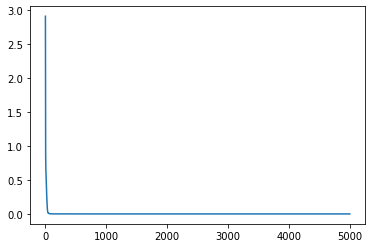

In [69]:
plt.plot(losss)

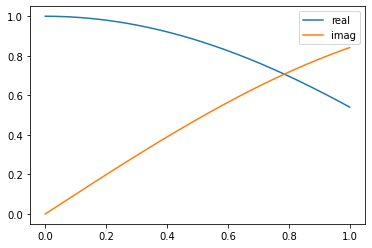

In [70]:
# True solutions
x_true = lambda t : tf.math.cos(t)
y_true = lambda t : tf.math.sin(t)

plt.plot(t, x_true(t) ,label = 'real')
plt.plot(t,  y_true(t), label = 'imag')
plt.legend()

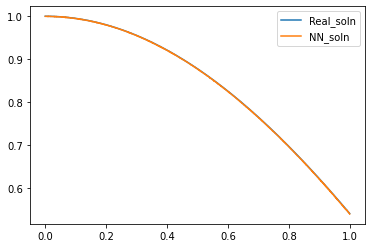

In [74]:
plt.plot(t, x_true(t) ,label = 'Real_soln')
plt.plot(t, z_hat(t)[:,0:1], label = 'NN_soln')
plt.legend()

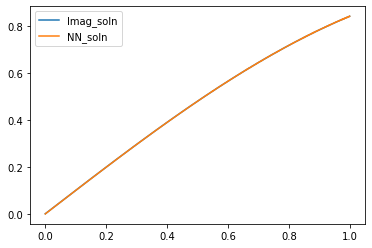

In [75]:
plt.plot(t, y_true(t) ,label = 'Imag_soln')
plt.plot(t, z_hat(t)[:,1:], label = 'NN_soln')
plt.legend()

In [19]:
# With batches
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(lr)
pinn = PINN(t, z_hat,z_init,optim)
start = time.time()
losss =  pinn.train_with_adam(batch_mode=True,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in is {(time.time() -start)//60.}s ')

initial loss : 0.0038005183450877666


 loss for epoch 0 : 0.01815023645758629

 loss for epoch 1000 : 8.906645962269977e-05

 loss for epoch 2000 : 6.714067421853542e-05

 loss for epoch 3000 : 1.1328036634949967e-05

 loss for epoch 4000 : 2.2607739083468914e-05
Final loss : 4.568042641039938e-06
final loss 4.568042641039938e-06 in is 4.0s 


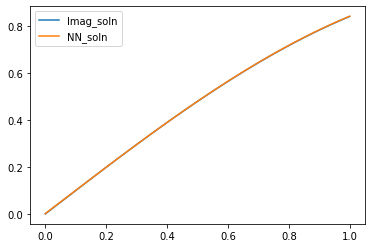

In [20]:
plt.plot(t, y_true(t) ,label = 'Imag_soln')
plt.plot(t, z_hat(t)[:,1:], label = 'NN_soln')
plt.legend()

In [46]:
np.min(z_hat(t)[:,0:1])

-0.078544706

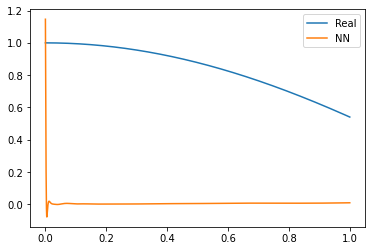

In [47]:
plt.plot(t, x_true(t) ,label = 'Real')
plt.plot(t, z_hat(t)[:,0:1], label = 'NN')
# plt.ylim(np.min(z_hat(t)[:,0:1]),)
plt.legend()

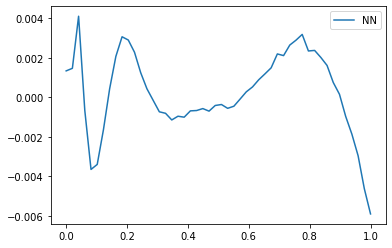

In [109]:
# plt.plot(t, y_true(t) ,label = 'Real')
plt.plot(t, z_hat(t)[:,1:], label = 'NN')
plt.legend()

In [22]:
x_hat = X_approx(num_of_hid_layers = 3, units_per_layer = 5, num_out=1, initialization = 0,activation = 'mish')
y_hat = Y_approx(num_of_hid_layers = 3, units_per_layer = 5, num_out=1, initialization = 0,activation = 'mish')

In [25]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(t) 
    x = x_hat(t)
    y = y_hat(t)
x_prime = tape.gradient(x,t)    
y_prime = tape.gradient(y,t)  
del tape
print(f'x prime {x_prime} \n y_prime {y_prime}')

x prime [[-0.04691141]
 [-0.04580088]
 [-0.04488641]
 [-0.04389558]
 [-0.043158  ]
 [-0.04230914]
 [-0.04150027]
 [-0.04096917]
 [-0.04029977]
 [-0.03980972]
 [-0.03932826]
 [-0.03878361]
 [-0.03844483]
 [-0.0380714 ]
 [-0.03777011]
 [-0.03750508]
 [-0.03729995]
 [-0.03701679]
 [-0.03681608]
 [-0.03672321]
 [-0.03664884]
 [-0.03652166]
 [-0.03646646]
 [-0.03636636]
 [-0.03637227]
 [-0.03632809]
 [-0.03634595]
 [-0.03639278]
 [-0.03642997]
 [-0.036442  ]
 [-0.03648344]
 [-0.03647701]
 [-0.03653761]
 [-0.03662881]
 [-0.03669764]
 [-0.03675947]
 [-0.03684453]
 [-0.03696074]
 [-0.03699692]
 [-0.03705414]
 [-0.03713073]
 [-0.03717476]
 [-0.03723507]
 [-0.03731408]
 [-0.03736116]
 [-0.03742646]
 [-0.03746198]
 [-0.03747474]
 [-0.03752461]
 [-0.03753534]
 [-0.03754866]
 [-0.03752921]
 [-0.03754056]
 [-0.03753002]
 [-0.03750424]
 [-0.03748228]
 [-0.0374103 ]
 [-0.03739306]
 [-0.03733627]
 [-0.03725561]
 [-0.03719684]
 [-0.03709857]
 [-0.03701421]
 [-0.03691789]
 [-0.03682933]
 [-0.03666963]
 [

In [29]:
class PINN:
    def __init__(self, t,model_x, model_y, x_init, y_init,optim):
        self.model_x = model_x
        self.model_y = model_y
        
        self.t = t
        self.x_init = x_init
        self.y_init = y_init
        
        self.optim = optim

        
    def get_derivatives(self,t):
        '''
        Calculate the derivatives and function that correspond to the ode

        input:
                t : independent variant

        output:
                value and corresponding derivatives
                
        

        '''
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t) 
            x = self.model_x(t)
            y = self.model_y(t)
        x_prime = tape.gradient(x,t)    
        y_prime = tape.gradient(y,t)   
        del tape
        
        return x,y,x_prime,y_prime   
        
    def ode_ic(self,t):
        x_hat,y_hat,x_prime,y_prime = self.get_derivatives(self.t)
       
        u1 =  x_prime + x_hat - 6.0*y_hat
        u2 =  y_prime - x_hat + 2.0*y_hat
#         Initial conditions
        x0,y0,x_prime0,y_prime0 = self.get_derivatives(tf.zeros_like(self.t))
#        
        u3 =  x0-self.x_init
        u4 =  y0 - self.y_init

        return u1,u2,u3,u4
        
    def loss(self,t):
        u1,u2,u3,u4 = self.ode_ic(t)
        mse_x  = tf.reduce_mean(tf.square(u1))
        mse_y  = tf.reduce_mean(tf.square(u2))
        mse_x0 = tf.reduce_mean(tf.square(u3))
        mse_y0 = tf.reduce_mean(tf.square(u4))
        return mse_x+mse_y+mse_x0+mse_y0
    
    
    def train_with_adam(self,batch_mode,epochs,batch_size,t):
#         which parameters???
        @tf.function
        def train_and_update(t):
    #         print(f'params : \n {self.model.trainable_variables}')
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_variables)
                los  = self.loss(t)
            dlossdpa = tape.gradient(los,self.model.trainable_variables) 
            self.optim.apply_gradients(zip(dlossdpa, self.model.trainable_variables))
            return los
        
        def train_and_update_batch(epochs, batch_size,t):
            loss_batch = []
            steps_per_epoch = int(t.shape[0]/batch_size)
            
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}')
            
            for epoch in range(epochs):
#                 print(f'Epoch {epoch} ', end = ".")
                for i in range(steps_per_epoch):
                    t_batch = t[i*batch_size:batch_size*(i+1)]
                    loss = train_and_update(t_batch).numpy()
                    loss_batch.append(loss)
                    
#                     if i%(steps_per_epoch/10)==0:
#                         print(end=".")
                        
                if epoch%1000==0:   
                    print(f'loss for epoch {epoch} : {loss}')  
            print(f'Final loss : {loss}')    
            return loss_batch      
                        
                        
        def train_whole_set(t):                
            losses =[]
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}')
            losses.append(initial_loss)

            for epoch in range(epochs):
            #     print(f'epoch {epoch}')
            #     print('epoch {}'.format(epoch),end = ".")
                loss = train_and_update(t).numpy()
                losses.append(loss)
            #     print(f'loss : {loss}')

                if epoch%1000==0:
                    print(f'loss for epoch {epoch} : {loss}') 
            #         print(end = ".")
            print(f'Final loss : {loss}') 
            return losses
        
        if batch_mode == True:
            losses = train_and_update_batch(epochs, batch_size,t)
        else:
            losses = train_whole_set(t)
            
        return losses   

In [34]:
optim = tf.keras.optimizers.Adam()
epochs = 5000
batch = 10
x_int = tf.constant(2.0, dtype = tf.float32)
y_int = tf.constant(0.0, dtype = tf.float32)


pinn = PINN(t,x_hat, y_hat, x_int, y_int,optim)

In [35]:
loss_list = pinn.train_with_adam(batch_mode=False,epochs=epochs,batch_size=batch,t=t)

NameError: in user code:

    File "/tmp/ipykernel_42571/1049554588.py", line 64, in train_and_update  *
        tape.watch(model.trainable_variables)

    NameError: name 'model' is not defined
